In [1]:
#! pip install pyLDAvis
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

with open("../data/all_reviews.pkl","rb") as f:
    reviews = pickle.load(f)
    
job_filter = pd.read_csv("../data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()

idx = reviews.clean_job_title.isin(job_filters)
reviews = reviews.loc[idx,:]

print( reviews.shape )
reviews.reset_index(drop=True,inplace=True)
display( reviews.head() )

(61122, 15)


,company_name,review_title,job_title,employee_status,location,date,review,pros,cons,rating,yes_helpful,no_helpful,industry,clean_job_title,language
0,EY,I had a great time working at EY,Software Developer,Former Employee,"Bengaluru, Karnataka",2020-03-02,Pros:\rGreat Learning Curve.\rPeer Culture is ...,NaN,NaN,4.0,0,0,accounting,software developer,en
1,EY,Great place to be,Office Administrator/Receptionist,Former Employee,Cork,2020-02-28,A lovely team and very pretty environment. I f...,NaN,NaN,5.0,0,0,accounting,office administrator receptionist,en
2,EY,Productive and FUN Place,System Engineer,Current Employee,"Hyderabad, Telangana",2020-02-25,It's feel like workplace where can utilize kno...,NaN,NaN,5.0,0,0,accounting,system engineer,en
3,EY,Fun to work at and has the best Work Culture,Associate Software Engineer,Former Employee,Bengaluru,2020-02-15,Supportive peers and leaders who are always pr...,NaN,NaN,5.0,0,0,accounting,associate software engineer,en
4,EY,Good Environment,Desktop Support Administrator & Business Opera...,Current Employee,"Nashville, TN",2020-01-24,EY is a very nice environment to work at. Tec...,NaN,NaN,4.0,0,0,accounting,desktop support administrator business operati...,en


In [2]:
#NLTK Stop words

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#extend stop word based on top 50 words
stop_words.extend(["new","lot","get","many","also","day","part","one","things","always","years","really"])

In [3]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [4]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [5]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [6]:
processed_docs = reviews['review'].map(prepare_text_for_lda)
processed_docs[:10]


0    [great, learning, curve, culture, great, balan...
1    [lovely, pretty, environment, welcome, great, ...
2    [workplace, utilize, knowledge, skill, managem...
3    [supportive, peer, leaders, present, guide, te...
4    [environment, tech, player, learn, something, ...
5    [energetic, vibrant, company, extrovert, deali...
6    [place, learn, technology, culture, awesome, p...
7    [flexibility, management, employee, benefit, i...
8    [help, family, bring, final, fruitful, result,...
9    [excellent, company, perfect, culture, annual,...
Name: review, dtype: object

In [7]:
from gensim import corpora
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(text) for text in processed_docs]

In [8]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.072*"company" + 0.043*"employee" + 0.040*"great" + 0.034*"career"')
(1, '0.043*"company" + 0.020*"employee" + 0.019*"people" + 0.018*"management"')
(2, '0.089*"learn" + 0.044*"technology" + 0.038*"skill" + 0.035*"working"')
(3, '0.060*"working" + 0.057*"great" + 0.043*"people" + 0.033*"enjoy"')
(4, '0.039*"learn" + 0.030*"hard" + 0.029*"client" + 0.029*"management"')
(5, '0.220*"would" + 0.057*"recommend" + 0.033*"organisation" + 0.029*"anyone"')
(6, '0.031*"system" + 0.028*"application" + 0.024*"server" + 0.022*"using"')
(7, '0.057*"project" + 0.046*"management" + 0.039*"salary" + 0.036*"company"')
(8, '0.058*"customer" + 0.025*"service" + 0.014*"sales" + 0.013*"order"')
(9, '0.031*"software" + 0.030*"business" + 0.027*"development" + 0.024*"product"')


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics = num_topics ,id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=2, limit=30, step=2)

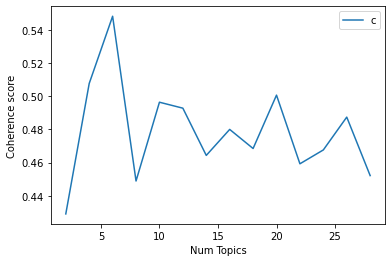

In [11]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4291
Num Topics = 4  has Coherence Value of 0.5077
Num Topics = 6  has Coherence Value of 0.5483
Num Topics = 8  has Coherence Value of 0.4489
Num Topics = 10  has Coherence Value of 0.4964
Num Topics = 12  has Coherence Value of 0.4928
Num Topics = 14  has Coherence Value of 0.4644
Num Topics = 16  has Coherence Value of 0.48
Num Topics = 18  has Coherence Value of 0.4685
Num Topics = 20  has Coherence Value of 0.5007
Num Topics = 22  has Coherence Value of 0.4593
Num Topics = 24  has Coherence Value of 0.4677
Num Topics = 26  has Coherence Value of 0.4875
Num Topics = 28  has Coherence Value of 0.4522


In [13]:
model_list

In [14]:
coherence_values

[0.42907962206297845,
 0.5077225923469375,
 0.5482700248632126,
 0.4489274659638163,
 0.4964312683383067,
 0.49283644844906055,
 0.46436155614394437,
 0.48003226818668154,
 0.4685218661385578,
 0.5006991981384463,
 0.4593016341455056,
 0.46765913915567997,
 0.4874538270526522,
 0.4521825901928289]

In [17]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.025*"working" + 0.024*"management" + 0.021*"learn" + 0.021*"worker" + '
  '0.021*"hard" + 0.019*"enjoyable" + 0.016*"typical" + 0.014*"enjoy" + '
  '0.013*"office" + 0.012*"project"'),
 (1,
  '0.026*"project" + 0.022*"development" + 0.020*"software" + 0.017*"business" '
  '+ 0.014*"experience" + 0.014*"client" + 0.012*"developer" + 0.012*"work" + '
  '0.012*"technology" + 0.012*"application"'),
 (2,
  '0.042*"company" + 0.021*"people" + 0.021*"employee" + 0.018*"management" + '
  '0.015*"would" + 0.013*"manager" + 0.013*"great" + 0.011*"change" + '
  '0.011*"work" + 0.010*"position"'),
 (3,
  '0.028*"customer" + 0.019*"system" + 0.015*"server" + 0.012*"service" + '
  '0.012*"support" + 0.011*"store" + 0.010*"report" + 0.010*"issue" + '
  '0.008*"provide" + 0.008*"network"'),
 (4,
  '0.058*"company" + 0.045*"balance" + 0.038*"great" + 0.037*"employee" + '
  '0.029*"place" + 0.029*"culture" + 0.028*"benefit" + 0.027*"management" + '
  '0.026*"salary" + 0.022*"opportunity"'),
 (

In [18]:
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)